### Import the Libraries:-

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt
from keras import layers

In VAEs, the sampling layer uses the output from two dense layers, z_mean and z_log_var, as inputs, followed by converting them into the normal distribution and passing them to the decoder layer.

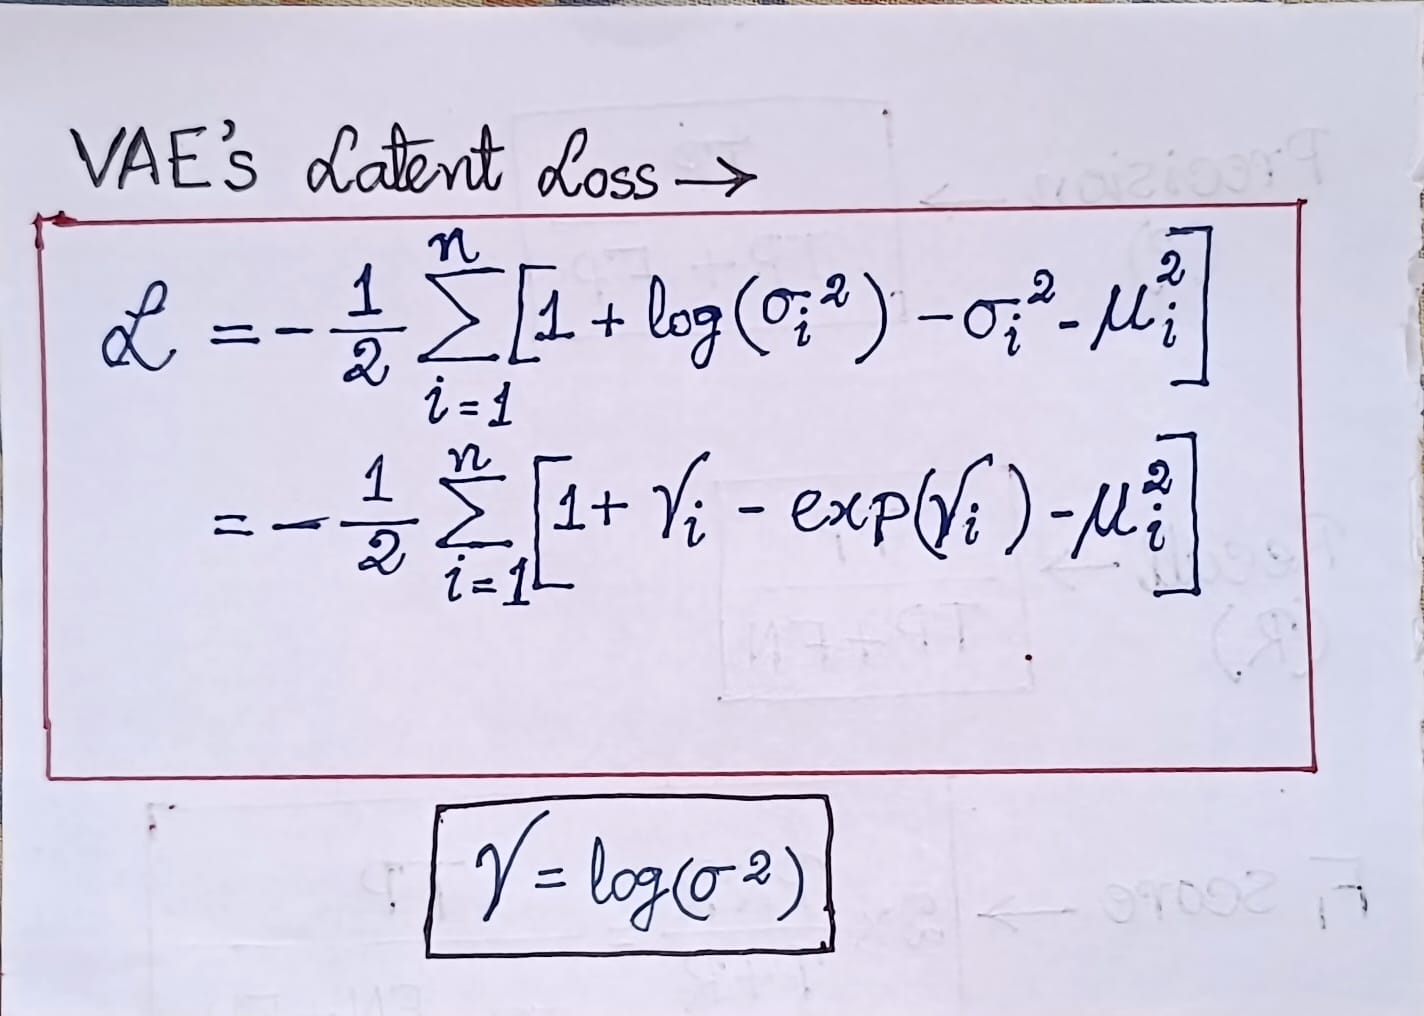

### Sampling Layer;

In [6]:
class Sampling(Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

*****We can create the encoder, using the functional API beacause the model is not entirely sequential

### Define Encoder Model;

In [9]:
latent_dim = 2

encoder_inputs = Input(shape =(28, 28, 1))

x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)

x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")

In [10]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In this step, we are defining the complete variational autoencoder architecture, followed by defining the training procedure with loss functions.

### Define Decoder Architecture:-

In [13]:
latent_inputs = keras.Input(shape =(latent_dim, ))

x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)

x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)

x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)

decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
    
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")

In [14]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In this step, we are defining the complete variational autoencoder architecture, followed by defining the training procedure with loss functions.

### Define the complete variational autoencoder architecture:-

In [17]:
class VAE(keras.Model):
    
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Here, we shall train the variational autoencoder model for 100 epochs after importing the fashion MNIST dataset.

#### Load the fashion mnist dataset:

In [20]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist_images = np.concatenate([x_train, x_test], axis = 0)

#### Expansion of dimension for adding a color map dimension:

In [22]:
fmnist_images = np.expand_dims(fmnist_images, -1).astype("float32") / 255

#### Compile and train the VAE mode:

In [24]:
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(fmnist_images, epochs = 10, batch_size = 64)

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - kl_loss: 5.2343 - loss: 309.0399 - reconstruction_loss: 303.8055
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - kl_loss: 5.1277 - loss: 281.0436 - reconstruction_loss: 275.9160
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - kl_loss: 4.7877 - loss: 275.1189 - reconstruction_loss: 270.3312
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - kl_loss: 4.5467 - loss: 271.8479 - reconstruction_loss: 267.3012
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - kl_loss: 4.3533 - loss: 269.5215 - reconstruction_loss: 265.1682
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - kl_loss: 4.1511 - loss: 267.6602 - reconstruction_loss: 263.5091
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - kl_loss: 4.0055 - loss: 266.1777 - reconstruction_loss: 262.1722
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - kl_loss: 3.8740 - loss: 264.8943 - reconstruction_loss: 261.0203
Epoch 9/10
1094/

Here we are displaying training results according to their latent space vectors.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

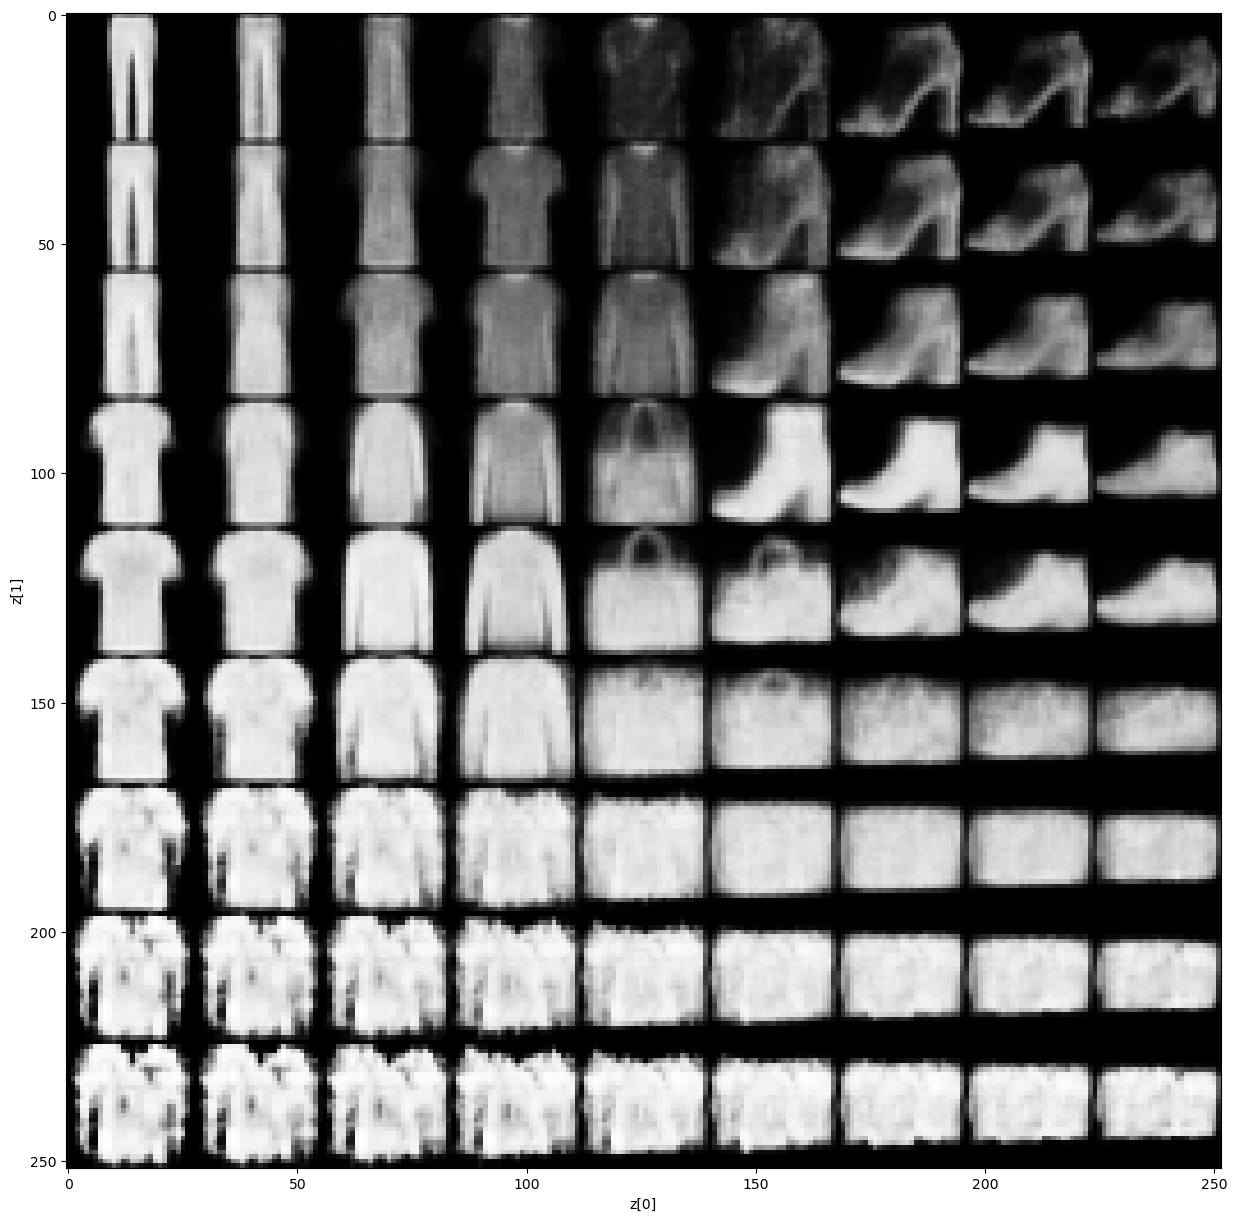

In [26]:
def plot_latent(encoder, decoder):
    
    n = 9
    img_dim = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((img_dim * n, img_dim * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            images = x_decoded[0].reshape(img_dim, img_dim)
            
            figure[
                i * img_dim : (i + 1) * img_dim,
                j * img_dim : (j + 1) * img_dim,
            ] = images
            
    plt.figure(figsize =(figsize, figsize))
    start_range = img_dim // 2
    end_range = n * img_dim + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_dim)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
#plt.xticks(pixel_range, sample_range_x)
#plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap ="Greys_r")
    plt.show()

plot_latent(encoder, decoder)


The scatter plot of the training data generated from the encoder has been generated to get a clear idea of the latent vector values.

In [28]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(10))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0] ------>")
    plt.ylabel("z[1] ------>")
    plt.show()

In [29]:
labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


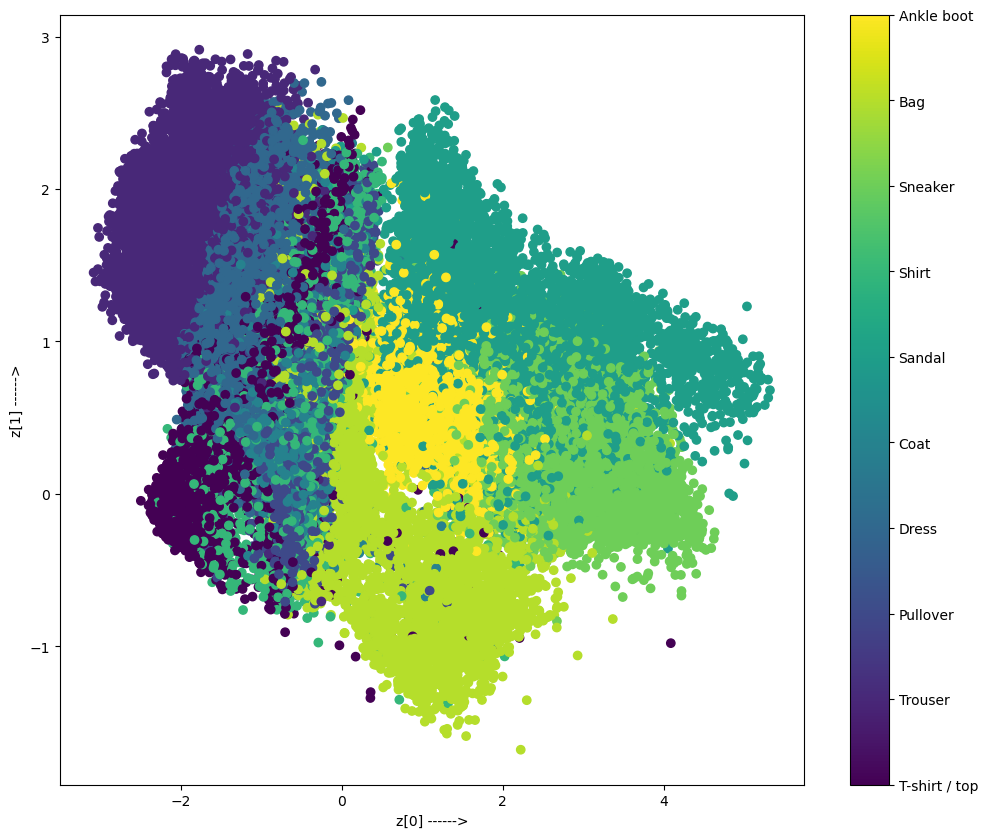

In [30]:
(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)